##  Infrabel Open Data platform

Raw Punctuality data from one day of train activity, 06/06/2019

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

from datetime import datetime
from datetime import timedelta

from scipy.stats import binom

import matplotlib.pyplot as plt
FIGSIZE = (12.0, 5.0)
plt.rcParams['figure.figsize'] = (12.0, 5.0)

pd.options.display.max_rows = 55
pd.options.display.max_colwidth = 500

In [3]:
#French file
point = pd.read_csv('data_raw_punctuality_xlsx.csv', sep=';')

point.head(2)

,Date de départ,Numéro du train,Relation,Opérateur,Ligne de départ,Heure réelle d'arrivée,Heure réelle de départ,Heure prévue d'arrivée,Heure prévue de départ,Retard à l'arrivée,Retard au départ,Direction de la relation,Nom du point d'arrêt,Ligne à l'arrivée,Date prévue d'arrivée,Date prévue de départ,Date réelle d'arrivée,Date réelle de départ
0,2019-06-06,115,IC 33,SNCB/NMBS,42,15:14:33,15:14:33,15:12:00,15:12:00,153.0,153.0,IC 33: LUXEMBOURG -> LIERS,STOUMONT,42,2019-06-06,2019-06-06,2019-06-06,2019-06-06
1,2019-06-06,115,IC 33,SNCB/NMBS,42,15:23:48,15:24:48,15:22:00,15:23:00,108.0,108.0,IC 33: LUXEMBOURG -> LIERS,AYWAILLE,42,2019-06-06,2019-06-06,2019-06-06,2019-06-06


In [4]:
#Dutch file
df = pd.read_csv('ruwe-gegevens-van-stiptheid-d-1.csv', sep=';')

df.head(2)

,Date van vertrek,Treinnummer,Relatie,Spoorwegoperatoren,Spoorlijn van vertrek,Uur van reële aankomst,Uur van reële vertrek,Uur van geplande aankomst,Uur van geplande vertrek,Vertraging bij aankomst,Vertraging bij vertrek,Richting van de relatie,Naam van de halte,Spoorlijn van aankomst,Datum van geplande aankomst,Datum van geplande vertrek,Datum van reële aankomst,Datum van reële vertrek
0,2019-06-13,115,IC 33,SNCB/NMBS,34,16:08:02,16:08:43,16:08:00,16:09:00,2.0,-17.0,IC 33: LUXEMBOURG -> LIERS,LIEGE-SAINT-LAMBERT,34,2019-06-13 00:00:00,2019-06-13,2019-06-13,2019-06-13
1,2019-06-13,1569,L B6,SNCB/NMBS,90,19:56:36,19:57:54,19:55:00,19:56:00,96.0,114.0,L B6: AALST -> SCHAARBEEK,DENDERLEEUW,50,2019-06-13 00:00:00,2019-06-13,2019-06-13,2019-06-13


In [7]:
# Checking that the type of data and the number of total entries match 

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71746 entries, 0 to 71745
Data columns (total 18 columns):
Date van vertrek               71746 non-null object
Treinnummer                    71746 non-null int64
Relatie                        71746 non-null object
Spoorwegoperatoren             71746 non-null object
Spoorlijn van vertrek          68165 non-null object
Uur van reële aankomst         68214 non-null object
Uur van reële vertrek          68219 non-null object
Uur van geplande aankomst      68214 non-null object
Uur van geplande vertrek       68219 non-null object
Vertraging bij aankomst        68218 non-null float64
Vertraging bij vertrek         68219 non-null float64
Richting van de relatie        65404 non-null object
Naam van de halte              71746 non-null object
Spoorlijn van aankomst         68158 non-null object
Datum van geplande aankomst    68214 non-null object
Datum van geplande vertrek     68219 non-null object
Datum van reële aankomst       68214 non-n

### Cleaning data 
#### Changing object columns to datetimes 
Then we can manipulate the time data. Reference to parse dates correctly: http://strftime.org/ 

In [8]:
df["Date van vertrek"] = pd.to_datetime(df["Date van vertrek"], format='%Y-%m-%d')

In [9]:
df["Datum van reële vertrek"] = pd.to_datetime(df["Datum van reële vertrek"], format='%Y-%m-%d')

In [10]:
df.iloc[:, 5:9] = df.iloc[:, 5:9].apply(pd.to_datetime, errors='coerce')

In [11]:
df.iloc[:, 14:17] = df.iloc[:, 14:17].apply(pd.to_datetime, errors='coerce')

In [12]:
#Checking that the column types are right. 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71746 entries, 0 to 71745
Data columns (total 18 columns):
Date van vertrek               71746 non-null datetime64[ns]
Treinnummer                    71746 non-null int64
Relatie                        71746 non-null object
Spoorwegoperatoren             71746 non-null object
Spoorlijn van vertrek          68165 non-null object
Uur van reële aankomst         68214 non-null datetime64[ns]
Uur van reële vertrek          68219 non-null datetime64[ns]
Uur van geplande aankomst      68214 non-null datetime64[ns]
Uur van geplande vertrek       68219 non-null datetime64[ns]
Vertraging bij aankomst        68218 non-null float64
Vertraging bij vertrek         68219 non-null float64
Richting van de relatie        65404 non-null object
Naam van de halte              71746 non-null object
Spoorlijn van aankomst         68158 non-null object
Datum van geplande aankomst    68214 non-null datetime64[ns]
Datum van geplande vertrek     68219 non-null d

#### Let's keep the dataframe where the date of departure is the same as the real date of departure

In [10]:
real = df[df['Date van vertrek'] == df['Datum van reële vertrek']]

Let's look at the unique values for each column

In [11]:
#Search unique values

def unique_counts(columns):
    for i in real.columns:
        count= df[i].nunique()
        print (i, ":", count)

In [13]:
unique_counts(real)

Date van vertrek : 1
Treinnummer : 3799
Relatie : 104
Spoorwegoperatoren : 3
Spoorlijn van vertrek : 136
Uur van reële aankomst : 42534
Uur van reële vertrek : 42468
Uur van geplande aankomst : 1433
Uur van geplande vertrek : 1396
Vertraging bij aankomst : 1923
Vertraging bij vertrek : 1879
Richting van de relatie : 204
Naam van de halte : 625
Spoorlijn van aankomst : 136
Datum van geplande aankomst : 2
Datum van geplande vertrek : 2
Datum van reële aankomst : 2
Datum van reële vertrek : 2


### Thoughts 

The data  is only one day of train activity  
There are 3724 trains, three railtrack operators, 204 train directions,  136 departure railines, 120 arrival railines, 620 stations.


- Arriving on time: Arriving before or 5:59 min after the planned arrival.  

Use case: Someone wants to go  to X town and needs to make a transfer. 
Solution: Use Bayes theorem
- Pa = Probability that the train will arrive late
- Pb = Probability that the train will leave late

General open data approaches:
- Punctuality 
- Train optimization
- Think about network analysis 
- Where are the new train lines going 
- Relate to other open data projects

SUSTAINABILITY 
- How much CO2 are we producing, noise etc
- How to promote the use of the train 
- What is the current use of old materials? Are they garbage? 
- How is garbage managed? 

In [51]:
real.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67960 entries, 0 to 71745
Data columns (total 18 columns):
Date van vertrek               67960 non-null datetime64[ns]
Treinnummer                    67960 non-null int64
Relatie                        67960 non-null object
Spoorwegoperatoren             67960 non-null object
Spoorlijn van vertrek          67906 non-null object
Uur van reële aankomst         64428 non-null datetime64[ns]
Uur van reële vertrek          67960 non-null datetime64[ns]
Uur van geplande aankomst      64428 non-null datetime64[ns]
Uur van geplande vertrek       67960 non-null datetime64[ns]
Vertraging bij aankomst        64432 non-null float64
Vertraging bij vertrek         67960 non-null float64
Richting van de relatie        62143 non-null object
Naam van de halte              67960 non-null object
Spoorlijn van aankomst         64379 non-null object
Datum van geplande aankomst    64428 non-null datetime64[ns]
Datum van geplande vertrek     67960 non-null d

In [ ]:
df.describe()

In [ ]:
real.describe()

## 1. What are the most delayed trains during 6/6/2019?

Let's consider all trains that delayed more than 15 min (900 seconds). Trains don't arrive very very earlier, but they can be very delayed. The mean of delay is ~ 1,100 seconds, or 18.3 minutes.

In [52]:
very_delayed= df[(df['Vertraging bij aankomst'] > 900)]

In [53]:
very_delayed.Treinnummer.nunique()

160

#### More dramatic delays on 6/6/2019

- From 3724 trains, only 160 have delayed more than 15 min, this is 4.3% of total trains 
- The train that caused more trouble was 2132, which delayed affected 50 trajectories 
- From the 160 delayed trains, 41% (65) delayed less than 5 trajectories, 13% (21) trains more than 20 trajectories 
- The mean number of delayed trajectories caused by a train was 10 

In [54]:
very = very_delayed.groupby('Treinnummer')['Treinnummer'].count().sort_values(ascending= False)

len(very)

160

In [55]:
very.describe()

count    160.000000
mean       9.581250
std        9.361014
min        1.000000
25%        2.000000
50%        6.000000
75%       13.250000
max       50.000000
Name: Treinnummer, dtype: float64

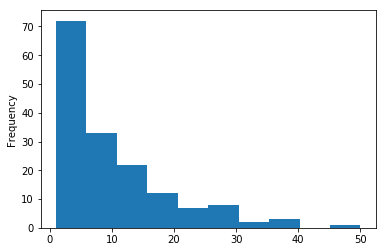

In [56]:
 very.plot.hist()

As the histogram above shows, most trains delay 5 or less trajectories, which is 40% of cases. Train 2132 is an outlier.

### 1.B : Analyzing the most delayed train, number 2132
 When we see chronologically in time the diferent delays, with 50 trajectories affected. We notice in the figure below that the train delayed, stabilized and kept delaying. According to the result in .describe(), the maximum delay of this train is 23.45 minutes. In addition, the delays in arrivals and departures follow similar curves.

In [14]:
mostdelayed = df[df['Treinnummer'] == 2132]

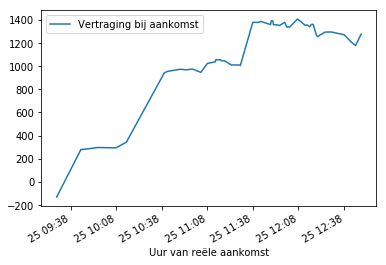

In [18]:
mostdelayed.plot(x= "Uur van reële aankomst", y= "Vertraging bij aankomst")

In [16]:
mostdelayed.describe()

,Treinnummer,Vertraging bij aankomst,Vertraging bij vertrek
count,57.0,57.000000,56.000000
mean,2132.0,1092.508772,1109.285714
std,0.0,363.032964,330.334085
min,2132.0,-131.000000,237.000000
25%,2132.0,1010.000000,1010.000000
50%,2132.0,1255.000000,1227.000000
75%,2132.0,1356.000000,1357.000000
max,2132.0,1407.000000,1458.000000


In [19]:
1407/60

23.45

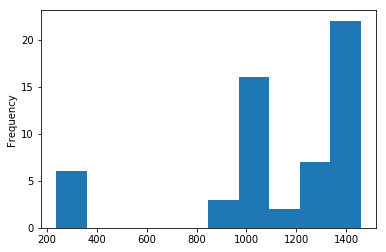

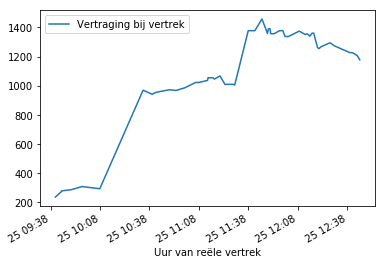

In [23]:
mostdelayed['Vertraging bij vertrek'].plot.hist(bins=10)

mostdelayed.plot(x= "Uur van reële vertrek", y= "Vertraging bij vertrek")

In [73]:
delayperstation = mostdelayed.groupby('Naam van de halte')[['Vertraging bij aankomst', 'Vertraging bij vertrek']].sum()

type(delayperstation)

pandas.core.frame.DataFrame

In [80]:
perstation = delayperstation.reset_index()

perstation

,Naam van de halte,Vertraging bij aankomst,Vertraging bij vertrek
0,ARLON,-131.0,237.0
1,ASSESSE,1010.0,1010.0
2,AYE,1023.0,1023.0
3,BEUZET,1357.0,1357.0
4,BLANMONT,1338.0,1338.0
5,BOIS D'AUSSE,1010.0,1010.0
6,BOSVOORDE,1262.0,1262.0
7,BRUSSEL-CENTRAAL,1205.0,1207.0
8,BRUSSEL-CONGRES,1226.0,1226.0
9,BRUSSEL-KAPELLEKERK,1178.0,1178.0


In [24]:
1300/60

21.666666666666668

The graph below is very dense, it plots the delay of arrivals vs. the name of the stations. In average of all trains per station has three categories, around 250, 1000 and 1300 seconds (21.66 minutes) of delay. We can conclude that the train system works wells.

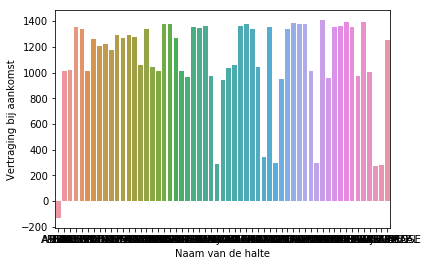

In [85]:
sns.barplot(x= 'Naam van de halte', y= 'Vertraging bij aankomst', data= perstation)

## 2) Reducing the data frame

Observing the graph below, with many outliers, 

We delete outliers that affect the mean and median values of the total set. 

- How much time will a passenger wait till taking another route? 
we consider the case that passengers will wait maximum 15 minutes before considering to take another route, which is 900 seconds. We will reduce the set to these data. 

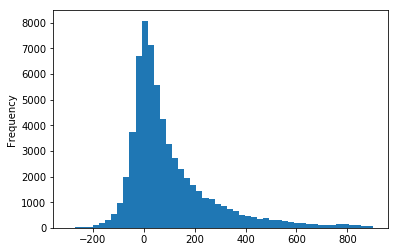

In [31]:
# After deleting outliers
data['Vertraging bij aankomst'].plot.hist(bins=50)

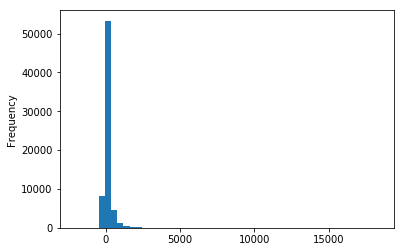

In [27]:
# Before deleting outliers
df['Vertraging bij aankomst'].plot.hist(bins=50)

In [28]:
#taking trains that only delay 15 min
data = df[(df['Vertraging bij aankomst'] <= 900) & (df['Vertraging bij vertrek'] <= 900)]

We reduced the dataframe from 67960 to 48821 entries

In [32]:
#The value of 300 seconds (5 minutes) was selected after observing the distribution function

data = data[(data['Vertraging bij aankomst'] > -300) & (data['Vertraging bij vertrek'] > - 300)]

In [30]:
data.describe()

,Treinnummer,Vertraging bij aankomst,Vertraging bij vertrek
count,63197.000000,63197.000000,63197.000000
mean,3476.822365,101.318781,107.738342
std,2319.557287,170.939532,169.111983
min,11.000000,-295.000000,-295.000000
25%,1988.000000,-5.000000,4.000000
50%,3037.000000,46.000000,51.000000
75%,4414.000000,154.000000,157.000000
max,19975.000000,900.000000,899.000000


#### Use case: Trains going Luxembourg -> Liers

In [18]:
luxembourg = data[data['Richting van de relatie'] == 'IC 33: LUXEMBOURG -> LIERS']

In [48]:
data['Richting van de relatie']

0                          IC 33: LUXEMBOURG -> LIERS
1                           L B6: AALST -> SCHAARBEEK
2                          IC 33: LUXEMBOURG -> LIERS
3                           L B6: AALST -> SCHAARBEEK
4                          IC 33: LUXEMBOURG -> LIERS
5                          IC 33: LUXEMBOURG -> LIERS
6                         IC 03: GENK -> BLANKENBERGE
7                         IC 03: GENK -> BLANKENBERGE
8                         IC 03: GENK -> BLANKENBERGE
9                         IC 03: GENK -> BLANKENBERGE
10                        IC 03: GENK -> BLANKENBERGE
11                        IC 03: GENK -> BLANKENBERGE
12                        IC 03: GENK -> BLANKENBERGE
13                        IC 03: GENK -> BLANKENBERGE
14                        IC 03: GENK -> BLANKENBERGE
15                        IC 03: GENK -> BLANKENBERGE
16                        IC 03: GENK -> BLANKENBERGE
17                        IC 03: GENK -> BLANKENBERGE
18                        IC

In [45]:
man = luxembourg.groupby('Treinnummer') 

man

In [46]:
luxembourg.groupby(['Treinnummer', 'Naam van de halte'])['Vertraging bij vertrek']

In [41]:
suma = luxembourg.groupby('Treinnummer')[['Vertraging bij aankomst', 'Vertraging bij vertrek']].sum()

suma

,Vertraging bij aankomst,Vertraging bij vertrek
Treinnummer,,
109,2015.0,2115.0
111,-80.0,120.0
113,1344.0,1217.0
115,-219.0,-137.0
117,-410.0,-283.0
119,455.0,280.0
121,4585.0,4601.0
123,3073.0,2845.0


In [125]:
data['Vertraging bij aankomst']/suma['Vertraging bij aankomst']

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
5       NaN
6       NaN
7       NaN
8       NaN
9       NaN
10      NaN
11      NaN
12      NaN
13      NaN
14      NaN
15      NaN
16      NaN
17      NaN
18      NaN
19      NaN
20      NaN
21      NaN
22      NaN
23      NaN
25      NaN
26      NaN
27      NaN
         ..
71690   NaN
71692   NaN
71693   NaN
71694   NaN
71695   NaN
71696   NaN
71698   NaN
71699   NaN
71700   NaN
71701   NaN
71702   NaN
71705   NaN
71706   NaN
71707   NaN
71708   NaN
71709   NaN
71710   NaN
71711   NaN
71712   NaN
71713   NaN
71714   NaN
71715   NaN
71716   NaN
71718   NaN
71721   NaN
71735   NaN
71737   NaN
Name: Vertraging bij aankomst, Length: 63197, dtype: float64

## 3) Grouping by the station of arrival and departure

In [41]:
# Making a copy of the dataset
data2 = data

In [42]:
# separating the values in the column name "Richting van de relatie". We create two new columns, with the station of departure and arrival
data2['richting_a'],  data2['richting_b'] = data2['Richting van de relatie'].str.split("->").str

In [43]:
# Making a third column for the name of the operator
data2['operator'], data2['richting_a'] = data2['richting_a'].str.split(":").str

In [45]:
data2.head(2)

,Date van vertrek,Treinnummer,Relatie,Spoorwegoperatoren,Spoorlijn van vertrek,Uur van reële aankomst,Uur van reële vertrek,Uur van geplande aankomst,Uur van geplande vertrek,Vertraging bij aankomst,...,Richting van de relatie,Naam van de halte,Spoorlijn van aankomst,Datum van geplande aankomst,Datum van geplande vertrek,Datum van reële aankomst,Datum van reële vertrek,richting_a,richting_b,operator
0,2019-06-13,115,IC 33,SNCB/NMBS,34,2019-06-25 16:08:02,2019-06-25 16:08:43,2019-06-25 16:08:00,2019-06-25 16:09:00,2.0,...,IC 33: LUXEMBOURG -> LIERS,LIEGE-SAINT-LAMBERT,34,2019-06-13,2019-06-13,2019-06-13,2019-06-13,LUXEMBOURG,LIERS,IC 33
1,2019-06-13,1569,L B6,SNCB/NMBS,90,2019-06-25 19:56:36,2019-06-25 19:57:54,2019-06-25 19:55:00,2019-06-25 19:56:00,96.0,...,L B6: AALST -> SCHAARBEEK,DENDERLEEUW,50,2019-06-13,2019-06-13,2019-06-13,2019-06-13,AALST,SCHAARBEEK,L B6


In [53]:
#grouping first by the departure and afterwards by the arrival station

group_a= data2.groupby(['richting_a', 'richting_b'])[['richting_a', 'richting_b', 'Naam van de halte']].count().sort_values(by= 'Naam van de halte', ascending= False)

group_a.head(10)

richting_a  \
richting_a                    richting_b                                 
 ANTWERPEN-CENTRAAL            NIVELLES                           1052   
 LIEGE-SAINT-LAMBERT           MONS                               1018   
                               BRUSSEL-ZUID                        984   
 MONS                          LIEGE-SAINT-LAMBERT                 976   
 LUXEMBOURG                    BRUSSEL-ZUID                        966   
 NIVELLES                      ANTWERPEN-CENTRAAL                  966   
 BRUSSEL-ZUID                  LIEGE-SAINT-LAMBERT                 948   
 BRUSSELS AIRPORT - ZAVENTEM   OOSTENDE                            913   
 LIEGE-GUILLEMINS              QUIEVRAIN                           907   
 OOSTENDE                      BRUSSELS AIRPORT - ZAVENTEM         897   

                                                            richting_b  \
richting_a                    richting_b                                 
 ANTWERPEN-CENTRAAL            NIVELLES                           1052   
 LIEGE-SAINT-LAMBERT           MONS                               1018   
                               BRUSSEL-ZUID                        984   
 MONS                          LIEGE-SAINT-LAMBERT                 976   
 LUXEMBOURG                    BRUSSEL-ZUID                        966   
 NIVELLES                      ANTWERPEN-CENTRAAL                  966   
 BRUSSEL-ZUID                  LIEGE-SAINT-LAMBERT                 948   
 BRUSSELS AIRPORT - ZAVENTEM   OOSTENDE                            913   
 LIEGE-GUILLEMINS              QUIEVRAIN                           907   
 OOSTENDE                      BRUSSELS AIRPORT - ZAVENTEM         897   

                                                            Naam van de halte  
richting_a                    richting_b                                       
 ANTWERPEN-CENTRAAL            NIVELLES                                  1052  
 LIEGE-SAINT-LAMBERT           MONS                                      1018  
                               BRUSSEL-ZUID                               984  
 MONS                          LIEGE-SAINT-LAMBERT                        976  
 LUXEMBOURG                    BRUSSEL-ZUID                               966  
 NIVELLES                      ANTWERPEN-CENTRAAL                         966  
 BRUSSEL-ZUID                  LIEGE-SAINT-LAMBERT                        948  
 BRUSSELS AIRPORT - ZAVENTEM   OOSTENDE                                   913  
 LIEGE-GUILLEMINS              QUIEVRAIN                                  907  
 OOSTENDE                      BRUSSELS AIRPORT - ZAVENTEM                897

In [61]:
#grouping first by the arrival and afterwards by the departure station

group_b =  data2.groupby(['richting_b', 'richting_a'])[['richting_a', 'richting_b']].count()

group_b.head(10)

richting_a  richting_b
richting_b          richting_a                              
 AACHEN HBF          SPA-GERONSTERE           15          15
 AALST               BRUSSEL-ZUID            270         270
                     SCHAARBEEK              459         459
                     VILVOORDE               265         265
 AMSTERDAM CENTRAAL  BRUSSEL-ZUID            333         333
                     PARIS-NORD              229         229
 ANTWERPEN-CENTRAAL  BRUSSEL-ZUID            354         354
                     DE PANNE                425         425
                     HAMONT                  281         281
                     HASSELT                 509         509

In [58]:
#grouping only by the departure station

group_c =  data2.groupby(['richting_b'])[['richting_a', 'richting_b']].count()
group_c.describe()

,richting_a,richting_b
count,80.000000,80.000000
mean,725.950000,725.950000
std,822.859016,822.859016
min,6.000000,6.000000
25%,197.250000,197.250000
50%,494.000000,494.000000
75%,928.750000,928.750000
max,4451.000000,4451.000000


Below we observe that the station with more departures and final arrivals is Antwerpen-Centraal, counting 4451. It is followed by Brussels-Zuid (3770), Leuven (2711) and the two airports near Brussels, Zaventem and Charleroi.

In [137]:
group_c.sort_values(by = ['richting_a', 'richting_b'], ascending= False)

C:\anaconda\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'richting_b' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


,richting_a,richting_b
richting_b,,
ANTWERPEN-CENTRAAL,4451,4451
BRUSSEL-ZUID,3770,3770
LEUVEN,2711,2711
BRUSSELS AIRPORT - ZAVENTEM,2588,2588
CHARLEROI-SUD,2238,2238
OOSTENDE,2091,2091
LIEGE-SAINT-LAMBERT,1924,1924
GENT-SINT-PIETERS,1851,1851
MONS,1699,1699


In [143]:
#Link with the file of importannt stations

import re

In [144]:
group_c.richting_a.nunique()


import re
def split_it(year):
    x = re.findall('brussel^', brussel)
    if x :
      return(x.group())



In [147]:
group_c['brussel'] = group_c.richting_a

#group_c.richting_a.apply(split_it)